# Caso do Churrasco

Neste notebook o nosso objetivo é trabalhar modelagem e algoritmos de otimização através do problema prático do churrasco. Este problema parte da necessidade de comprar itens para realizar o churrasco de fim de ano, porém temos uma grande limitação: orçamento. Desta forma, queremos encontrar quais itens compramos de modo a utilizarmos a maior parte do dinheiro, obter a maior quantidade de alimentos e também atingir uma boa diversidade.

Como fica evidente, este problema é uma otimização multiobjetivo. Nossa função fitness (ou função objetivo) precisará lidar com esta particularidade e, em especial, permitir alterarmos a forma de compilar cada objetivo de forma isolada durante a execução dos algoritmos.

Trataremos neste notebook a concepção do problema, a modelagem, configuração, testes e por fim algoritmos de otimização. Resumidamente, os conceitos abordados serão:

- Organização de parâmetros de configuração de entrada do problema;
- Codificação de modelo para o problema utilizando OO;
- Formas de utilizar diversos objetivos para avaliar soluções;
- Implementar busca local com Algoritmo da Subida de Encosta;
- Solucionar problema com Algoritmo de Têmpera Simulada;
- Criar Algoritmo Genético para solucionar o problema;
- Adicionar etapa de explotação com busca local para aprimorar Algoritmo Genético

# Configuração de Ambiente

Nesta seção configuraremos todas as bibliotecas necessárias, bem como os caminhos para arquivos que serão utilizados. Este notebook faz parte de um repositório maior, portanto foi desenvolvido para trabalhar sinergicamente com os demais diretórios, em especial o de armazenamento de dados, onde está o arquivo de itens disponíveis para a compra. Caso deseje executar localmente, atente-se apenas para manter os diretórios do repositório original sem alteração, de modo que os comandos abaixo consigam encontrar os caminhos desejados.

Vamos trabalhar também com uma biblioteca auxiliar de tipagem, com o intuito de deixar mais claro o que são as variáveis trabalhadas em cada parte do código, sobretudo os argumentos de construtores e métodos. Desta forma, nosso código ficará mais legível e, mesmo depois de algum tempo sem nos debruçar sobre o código, conseguiremos entender o que cada variável significa. Outra grande funcionalidade é a possibilidade de utilizar o intellisense do editor de texto, o que é de grande ajuda quando estamos escrevendo código.

Por fim, utilizaremos o inglês para nomear variáveis. Esta é uma decisão puramente estética pessoal, para evitar a escrita "errada" de palavras em português quando precisarmos remover acentuações e caracteres especiais. Saiba que esta prática não representa nenhum tipo de convenção ou melhoria de performance, apenas se trata de uma forma de escrita pessoal.

In [228]:
import os
import math
import json
import random
from enum import Enum
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from typing import List, Tuple, Callable, Dict

BASE_PATH = os.path.dirname(os.getcwd())
ITEMS_PATH = f"{BASE_PATH}/data/churrasco.json"

# Criação do Modelo

O ponto de partida para começar a codificar é definir, textualmente, os requisitos que nosso modelo precisa entregar. Esta etapa serve como bússula para quando formos escrever o código, evitando que fiquemos travados diante da tela. Assim, são requisitos do modelo:

- Configurar e processar os itens que podem ser comprados;
- Registar informação de limite do orçamento disponível (restrição);
- Forma de representar a solução do problema, ou seja, itens a serem comprados;
- Procedimento de avaliar validade de uma solução, confrontando com o orçamento;
- Estratégia para encontrar soluções vizinhas, dada uma solução qualquer;
- Método de avaliação da solução a partir de regras específicas (função fitness).

## Itens disponíveis

Para configurar os itens de entradas utilizaremos um arquivo JSON como exemplificado abaixo. A estratégia deste JSON é configurar itens de forma genérica, introduzindo o conceito de compra por lote. Carnes geralmente são compradas por kg, então sua "Unidades/Lote" possui valor *null*. Por outro lado, o pão de alho é comprado por lotes de 10 unidades. O campo "Incremento" informa de quanto em quanto um item pode ser comprado. Novamente, carnes poderiam ser compradas em qualquer quantidade, porém não é prático pedir frações menores que 100g. Por outro lado, o pão de alho sempre é comprado de lote em lote, ou seja de 1 em 1. Os campos "Preço/Lote" e "kg/Lote" são autoexplicativos, indicam o preço pago por um lote do item (para as carnes um lote é 1kg e para o pão de alho o lote são 10 pães) e quanto de massa o lote tem, respectivamente.
```
{
    "Alcatra": {
        "Preço/Lote": 47.99,
        "Unidades/Lote": null,
        "kg/Lote": 1,
        "Incremento": 0.1
    },
    "Pão de Alho": {
        "Preço/Lote": 15.97,
        "Unidades/Lote": 10,
        "kg/Lote": 0.8,
        "Incremento": 1
    },
    "Picanha": {...},
    "Pernil": {...},
    ...
}
```

Com o JSON estruturado, vamos criar a classe responsável por transcrever esta estrutura de dados. Esta será a classe utilizada pelo modelo para gerenciar os itens disponíveis para compra, evitando trabalhar com strings de chave e valor, acessando o JSON (transformado em dicionário no python.).

In [229]:
class Item:
    def __init__(self, name: str, batch_price: float,
        increment: float | None, batch_kg: float
    ) -> None:
        self.name = name
        self.batch_kg = batch_kg
        self.increment = increment
        self.batch_price = batch_price

## Processamento do arquivo

O método de carga **process_json** é responsável por ler o arquivo JSON convertido para dicionário, criando as instâncias de Item para cada item cadastrado no arquivo. Assim, alterações de preço ou de possibilidades de compra ficam isoladas do código, sendo manipuladas apenas no arquivo. Como estas informações não são interessantes de serem alteradas para teste, não é ruim deixar estático no JSON.

Lembre-se, você pode alterar os itens disponíveis e preços para atender à sua realidade, caso deseje. Basta alterar o arquivo no diretório específico, mantendo apenas a estrutura de atributos apresentada anteriormente.

## Representação da solução, restrição e validação

A forma mais simples de representar uma solução é por meio de listas, em que cada índice corresponde a quantidade do item, de modo que o índice é o mesmo no atributo interno gerado após o processamento do arquivo. Como a solução é manipulada apenas dentro da classe, não se espera problemas de desconexão entre índices de cada item, além de permitir melhor dinamicidade na geração da solução, que fica condicionada ao tamanho de itens cadastrados no arquivo JSON.

Este problema possui uma única restrição, que é o orçamento máximo disponível. Como é interessante nos próximos passos realizar testes com diferentes orçamentos, esta restrição foi passada dentro do construtor, lida durante a execução do código. Também seria possível mover as restrições para um arquivo, porém neste caso optamos por trabalhar com a passagem de restrição durante o código, dada as particularidades do caso.

Por fim, existindo uma solução e a restrição, o método **valid_solution** é responsável por verificar se a solução é viável. Em outras palavras, verifica se ela atende às restrições existentes. No nosso caso, a única restrição é se as quantidades compradas não extrapolam o valor disponível no orçamento.

## Soluções aleatórias e vizinhas

Todos os algoritmos de otimização precisam de uma estimativa inicial, portanto o método **random_solution** é responsável por entregar esta funcionalidade. Outra funcionalidade são as soluções vizinhas, suprida pelo método **near_solution**. Para este método, a estratégia foi utilizar o atributo de incremento, uma vez que todas os itens foram quantizados. Porém, para deixar genérico, um *if* regula o caso de incremento *null*, fazendo com que ele se torne 5% do valor atual.

## Função objetivo

Como o nosso problema é multiobjetivo, vamos criar um enum para listar os diferentes objetivos que serão trabalhados. Cada objetivo vai ser um item no enum, que será utilizado para compor a função objetivo de modo dinâmico. A estratégia mais simples para se trabalhar com funções multiobjetivo é atribuir pesos para cada objetivo e então computar o valor final como a média ponderada. Porém existe uma atenção para se aplicar esta abordagem: as dimensões e unidades precisam ser equivalentes.

Neste caso vamos trabalhar com três funções objetivo, todas que variam entre 0 e 1. São elas:
- Porcentagem de gasto do orçamento;
- Porcentagem de massa comprada;
- Índice de variedade.

A porcentagem de gasto do orçamento é simples, basta dividir o total gasto com a solução pelo orçamento disponível. A porcentagem de massa comprada exige um trabalho extra, precisamos encontrar a massa mássima que poderíamos comprar com o orçamento disponível. Para isso, basta encontrar o produto com menor R$/kg e verificar o quanto seria possível comprar de massa dele. Este cálculo é feito quando o processamento do arquivo JSON é realizado e a massa mássima (referência para o cálculo deste objetivo) é armazenado no atributo da classe. Por fim, o índice de variedade é uma definição nossa. Vamos definir como a razão entre a menor fração mássica da solução e a fração mássica no caso de todos os itens serem comprados de forma igualitária (em massa).

Importante pontuar que o índice de variedade é uma medida que chamados de proxy. Não existe um índice de variedade, então este indicador que comentamos é uma forma de aproximar a ideia de diversidade de itens comprados. Precisamos que ele atenda a ideia de ser zero quando existe algum item não comprado (0 na solução) e que aumente de acordo com o aumento da quantidade comprada. Esta forma de cálculo não é única, poderíamos definir outro índice de variedade como sendo $ \sum_{i=1}^n P_i \over n $, em que n é o número de itens disponíveis e $ P_i $ é uma variável binária que assume o valor 1 se a quantidade do item for maior que zero e assume 0 caso contrário.

In [230]:
class Objective(Enum):
    MASSA_TOTAL = 1
    GASTO_TOTAL = 2
    VARIEDADE = 3


class Barbecue:
    def __init__(self, money_limit: float) -> None:
        self.items: List[Item] = []
        self.mass_limit: float = None
        self.money_limit = money_limit
        self.relate_objective: Dict[Objective, Callable[[List[float]], float]] = {
            Objective.MASSA_TOTAL: self.calculate_mass,
            Objective.GASTO_TOTAL: self.calculate_spent,
            Objective.VARIEDADE: self.calculate_variety
        }

    def random_solution(self) -> List[float]:
        while True:
            solution: List[float] = []
            for i in range(0, len(self.items)):
                multiply = random.randint(0, 10)
                quantity = round(self.items[i].increment * multiply, 1)
                solution.append(quantity)

            if self.valid_solution(solution):
                break

        return solution

    def near_solution(self, solution: List[float], quantity: int) -> List[List[float]]:
        new_solutions: List[List[float]] = []
        
        for _ in range(0, quantity):
            while True:
                new_solution = solution.copy()
                i = random.randint(0, len(solution) - 1)
                signal = 1 if random.random() < 0.5 else -1
                step = self.items[i].increment if self.items[i].increment is not None else 0.05 * new_solution[i]
                new_solution[i] = round(new_solution[i] + signal * step, 1)

                if self.valid_solution(new_solution):
                    break

            new_solutions.append(new_solution)
        
        return new_solutions
    
    def mutate_solution(self, solution: List[float]) -> List[float]:
        while True:
            new_solution = solution.copy()
            i = random.randint(0, len(solution) - 1)
            signal = 1 if random.random() < 0.5 else -1
            step = self.items[i].increment if self.items[i].increment is not None else 0.05 * new_solution[i]
            new_solution[i] = round(new_solution[i] + signal * step, 1)

            if self.valid_solution(new_solution):
                break
            
        return new_solution

    def calculate_fitness(self, solution: List[float],
        compose: List[Tuple[Objective, float]]
    ) -> float:
        score, weights = 0, 0
        for objective, weight in compose:
            fitness = self.relate_objective[objective](solution)
            score = score + fitness * weight
            weights = weights + weight
        return score / weights

    def calculate_spent(self, solution: List[float]) -> float:
        spent = 0
        for i in range(0, len(solution)):
            spent = spent + self.items[i].batch_price * solution[i]
        return spent / self.money_limit
    
    def calculate_mass(self, solution: List[float]) -> float:
        mass = 0
        for i in range(0, len(solution)):
            mass = mass + self.items[i].batch_kg * solution[i]
        return mass / self.mass_limit
    
    def calculate_variety(self, solution: List[float]) -> float:
        # Encontra a massa de cada item
        mass = []
        for i in range(0, len(solution)):
            mass.append(self.items[i].batch_kg * solution[i])
        
        # Calcula a fração mássica de cada item
        mass_total = sum(mass)
        frac = [m / mass_total for m in mass]

        # Define diversidade como a razão entre a menor fração
        # mássica e a fração mássica em condições totalmente
        # iguais para todos os itens
        equals_frac = 1 / len(solution)
        return min(frac) / equals_frac

    def process_json(self, data: dict) -> None:
        # Carrega itens do json
        items: List[Item] = []
        for item in data.keys():
            items.append(Item(
                item,
                data[item]["Preço/Lote"],
                data[item]["Incremento"],
                data[item]["Massa/Lote"]
            ))
        self.items = items

        # Calcula a massa máxima que pode ser obtida, resultado
        # do gasto de todo o orçamento no item de menor R$/kg
        max_mass = 0
        for item in self.items:
            spent, multiply = 0, 0
            while spent < self.money_limit:
                spent = spent + item.increment * item.batch_price
                multiply = multiply + item.increment

            # Remova um incremento, caso não queira ultrapassar
            # o orçamento disponível
            # multiply = multiply - item.increment
            item_mass = multiply * item.batch_kg
            if item_mass > max_mass:
                max_mass = item_mass

        self.mass_limit = max_mass

    def valid_solution(self, solution: List[float]) -> bool:
        # Inicia lista de validações
        validations: List[bool] = []

        # Verifica se a restrição de não negatividade é respeitada
        valid = True
        for s in solution:
            if s < 0:
                valid = False
        validations.append(valid)

        # Verifica se a resposta é toda vazia
        valid = False
        for s in solution:
            if s > 0:
                valid = True
        validations.append(valid)

        # Verifica se a restrição de orçamento é respeitada
        spent, valid = 0, True
        for i in range(0, len(solution)):
            spent = spent + self.items[i].batch_price * solution[i]

        if spent > self.money_limit:
            valid = False
        
        validations.append(valid)

        # Verifica se todas as restrições foram cumpridas
        return True if validations.count(False) == 0 else False
        
    def print_solution(self, solution: List[float]) -> None:
        print("**** Apresentando especificidades da solução ****")
        print(f"Total gasto: {round(self.calculate_spent(solution) * 100, 1)}%")
        print(f"Massa atingida: {round(self.calculate_mass(solution) * 100, 1)}%")
        print(f"Índice de variedade: {round(self.calculate_variety(solution), 2)}")
        print()

        for i in range(0, len(solution)):
            spent = self.items[i].batch_price * solution[i]
            mass = self.items[i].batch_kg * solution[i]
            print(f"{self.items[i].name}: R$ {round(spent, 2)} ({round(mass, 1)} kg)")
        print()

## Executando o Modelo

Os blocos abaixo possuem função ilustrativa, para visualizar a execução dos métodos criados. É importante, além de desenvolver, ter uma seção para testar o que foi feito, como é a interação dos métodos e se tudo está funcionando como deveria. Em aplicações mais robustas, um módulo de testes é muito bem-vindo, mas aqui vamos simplificar um pouco, já que o objetivo não é colocar o modelo em produção, mas sim executar um trabalho de otimização.

In [231]:
# Carregando o arquivo JSON
with open(ITEMS_PATH) as file:
    data = json.load(file)

barbecue = Barbecue(money_limit=300)
barbecue.process_json(data)

In [232]:
# Encontrando uma solução aleatória
solution = barbecue.random_solution()
barbecue.print_solution(solution)

**** Apresentando especificidades da solução ****
Total gasto: 84.7%
Massa atingida: 57.4%
Índice de variedade: 0.11

Alcatra: R$ 9.6 (0.2 kg)
Linguiça: R$ 19.99 (1.0 kg)
Pernil: R$ 11.19 (0.7 kg)
Lombo: R$ 15.29 (0.9 kg)
Picanha: R$ 54.39 (0.8 kg)
Pão de Alho: R$ 143.73 (7.2 kg)



In [233]:
# Calculando o fitness final, compondo os pesos de cada objetivo
compose = [
    (Objective.MASSA_TOTAL, 0.3),
    (Objective.GASTO_TOTAL, 0.5),
    (Objective.VARIEDADE, 0.2)
]
fitness_total = barbecue.calculate_fitness(solution, compose)
print(f"Fitness geral: {round(fitness_total, 3)}")

Fitness geral: 0.618


In [234]:
# Encontra vizinhos da solução
neighbors = barbecue.near_solution(solution, quantity=10)
print(f"Representação da solução inicial:\n{solution}")
print()
for n in neighbors:
    print(f"Vizinho: {n}")

Representação da solução inicial:
[0.2, 1.0, 0.7, 0.9, 0.8, 9]

Vizinho: [0.2, 1.0, 0.7, 0.9, 0.8, 8]
Vizinho: [0.2, 1.0, 0.7, 0.9, 0.7, 9]
Vizinho: [0.2, 1.0, 0.7, 1.0, 0.8, 9]
Vizinho: [0.2, 0.9, 0.7, 0.9, 0.8, 9]
Vizinho: [0.2, 0.9, 0.7, 0.9, 0.8, 9]
Vizinho: [0.2, 1.1, 0.7, 0.9, 0.8, 9]
Vizinho: [0.2, 0.9, 0.7, 0.9, 0.8, 9]
Vizinho: [0.2, 1.0, 0.7, 0.9, 0.8, 8]
Vizinho: [0.2, 0.9, 0.7, 0.9, 0.8, 9]
Vizinho: [0.2, 1.0, 0.7, 0.8, 0.8, 9]


# Algoritmos de otimização

Com o modelo de comportamento do nosso problema, podemos finalmente partir para a implementação dos algoritmos. Neste notebook vamos utilizar algoritmos aproximados, dada a grande simplicidade e apmpla aplicabilidade. São eles:

- Subida de Encosta (Hill Climbing)
- Têmpera Simulada (Simulated Annealing)
- Algorítmo Genético (Genect Algorithm)

In [235]:
class Optima:
    def __init__(self, method: str) -> None:
        self.solution: List[float] = None
        self.hist_fitness: float = None
        self.fitness: float = None
        self.method = method

    def show_evolution(self) -> None:
        # Log geral em tela
        evolution = (self.fitness - self.hist_fitness[0]) / self.hist_fitness[0]
        print(f"***** Avaliação de desempenho do {self.method} *****")
        print(f"Fitness inicial: {round(self.hist_fitness[0], 3)}")
        print(f"Fitness final: {round(self.fitness, 3)}")
        print(f"Evolução {round(evolution * 100, 1)}%")

        # Cria plot com valores x e y
        ax: Axes = None
        plt.style.use("ggplot")
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(7, 4))
        iterations = [i for i in range(0, len(self.hist_fitness))]
        values = [v for v in self.hist_fitness]

        # Organiza informações do gráfico
        ax.set_title(f"Evolução obtida pelo {self.method}")
        ax.set_ylabel("Função objetivo")
        ax.set_xlabel("Iterações")
        ax.plot(iterations, values)

        plt.show()

## Algoritmo da Subida de Encosta

In [236]:
class HillClimbing:
    def __init__(self, model: Barbecue, compose: List[Tuple[Objective, float]]) -> None:
        self.compose = compose
        self.model = model

    def run(self, start_solution: List[float]=None, n_neighbors=100) -> Optima:
        # Se a solução inicial não for fornecida, gera uma aleatória pelo modelo
        if start_solution is None:
            start_solution = self.model.random_solution()

        # Inicia as variáveis da iteração
        current_solution = start_solution
        current_fitness = self.model.calculate_fitness(current_solution, self.compose)
        fitness_hist = [current_fitness]

        while True:
            # Inicia variável de controle de parada
            improved = False

            # Percorre todos os vizinhos disponível, atualizando as variáveis de interação
            # no caso de maior atingimento da função objetivo
            for neighbor in self.model.near_solution(current_solution, quantity=n_neighbors):
                fitness = self.model.calculate_fitness(neighbor, self.compose)
                if fitness > current_fitness:
                    current_solution = neighbor
                    current_fitness = fitness
                    improved = True

            # Caso não ocorra mudança no fitness, quebra o laço
            if not improved:
                break

            # Atualiza a lista de histórico da função objetivo
            fitness_hist.append(current_fitness)

        # Cria a instância para resposta e encerra a função
        optima = Optima("Subida de Encosta")
        optima.fitness = current_fitness
        optima.solution = current_solution
        optima.hist_fitness = fitness_hist
        return optima

    def run_restart(self, n_neighbors=100, restart=5) -> Optima:
        # Variáveis de controle da melhor solução das reinicializações
        global_solution: List[float] = None
        hist: List[float] = []
        global_fitness = 0

        for i in range(0, restart):
            # Log de acompanhamento
            print(f"Restart {i + 1}", end="\r")
            
            # Executa o algoritmo padrão da subida de encosta
            optima = self.run(n_neighbors=n_neighbors)
            hist.extend(optima.hist_fitness)

            # Verifica se a solução encontrada é a melhor
            if optima.fitness > global_fitness:
                global_fitness = optima.fitness
                global_solution = optima.solution

        # Configura resposta
        optima = Optima("Subida de Encosta com Reinicialização")
        optima.solution = global_solution
        optima.fitness = global_fitness
        optima.hist_fitness = hist
        return optima

### Execuções

In [237]:
# Carregando o arquivo JSON
with open(ITEMS_PATH) as file:
    data = json.load(file)

# Instancia o modelo
barbecue = Barbecue(money_limit=300)
barbecue.process_json(data)

# Define a estrutura da função objetivo
compose = [
    (Objective.GASTO_TOTAL, 0.3),
    (Objective.MASSA_TOTAL, 0.3),
    (Objective.VARIEDADE, 0.4)
]

**** Apresentando especificidades da solução ****
Total gasto: 99.9%
Massa atingida: 73.9%
Índice de variedade: 0.04

Alcatra: R$ 4.8 (0.1 kg)
Linguiça: R$ 2.0 (0.1 kg)
Pernil: R$ 14.39 (0.9 kg)
Lombo: R$ 5.1 (0.3 kg)
Picanha: R$ 33.99 (0.5 kg)
Pão de Alho: R$ 239.55 (12.0 kg)

***** Avaliação de desempenho do Subida de Encosta *****
Fitness inicial: 0.355
Fitness final: 0.539
Evolução 51.9%


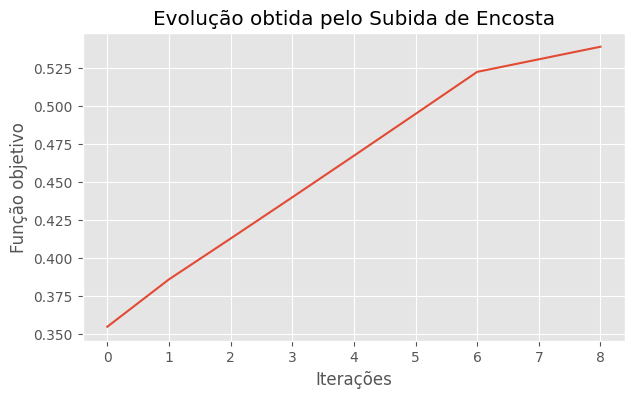

In [238]:
# Encontra o resultado com a execução simples
hill_climbing = HillClimbing(barbecue, compose)
optima = hill_climbing.run(n_neighbors=300)

barbecue.print_solution(optima.solution)
optima.show_evolution()

**** Apresentando especificidades da solução ****
Total gasto: 99.8%
Massa atingida: 61.7%
Índice de variedade: 0.41

Alcatra: R$ 43.19 (0.9 kg)
Linguiça: R$ 17.99 (0.9 kg)
Pernil: R$ 12.79 (0.8 kg)
Lombo: R$ 13.59 (0.8 kg)
Picanha: R$ 67.99 (1.0 kg)
Pão de Alho: R$ 143.73 (7.2 kg)

***** Avaliação de desempenho do Subida de Encosta com Reinicialização *****
Fitness inicial: 0.454
Fitness final: 0.65
Evolução 43.3%


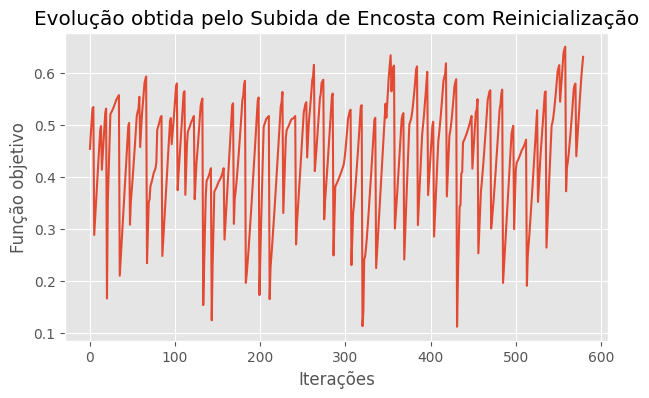

In [239]:
# Encontra o resultado com a execução com reinicializações
hill_climbing = HillClimbing(barbecue, compose)
optima = hill_climbing.run_restart(n_neighbors=300, restart=50)

barbecue.print_solution(optima.solution)
optima.show_evolution()

## Algoritmo da Têmpera Simulada

In [240]:
class SimulatedAnnealing:
    def __init__(self, model: Barbecue, compose: List[Tuple[Objective, float]]) -> None:
        self.compose = compose
        self.model = model

    def probability_accept(self, temperature: float,
        current_fitness: float, new_fitness: float
    ) -> float:
        if new_fitness > current_fitness:
            return 1
        else:
            return math.exp(-1 * abs(new_fitness - current_fitness) / temperature)

    def run(self, temperature: float, cooling_rate: float, start_solution=None, iterations=2000) -> Optima:
        if start_solution is None:
            start_solution = self.model.random_solution()

        current_solution = start_solution
        current_fitness = self.model.calculate_fitness(current_solution, self.compose)
        hist: List[float] = [current_fitness]

        for _ in range(0, iterations):
            neighbor = self.model.near_solution(current_solution, quantity=1)[0]
            fitness = self.model.calculate_fitness(neighbor, self.compose)
            probability = self.probability_accept(temperature, current_fitness, fitness)

            if random.random() < probability:
                current_solution = neighbor
                current_fitness = fitness

            hist.append(current_fitness)
            temperature = temperature * cooling_rate

        optima = Optima("Têmpera Simulada")
        optima.solution = current_solution
        optima.fitness = current_fitness
        optima.hist_fitness = hist
        return optima

### Execuções

**** Apresentando especificidades da solução ****
Total gasto: 99.6%
Massa atingida: 43.1%
Índice de variedade: 0.74

Alcatra: R$ 57.59 (1.2 kg)
Linguiça: R$ 19.99 (1.0 kg)
Pernil: R$ 15.99 (1.0 kg)
Lombo: R$ 16.99 (1.0 kg)
Picanha: R$ 156.38 (2.3 kg)
Pão de Alho: R$ 31.94 (1.6 kg)

***** Avaliação de desempenho do Têmpera Simulada *****
Fitness inicial: 0.406
Fitness final: 0.724
Evolução 78.6%


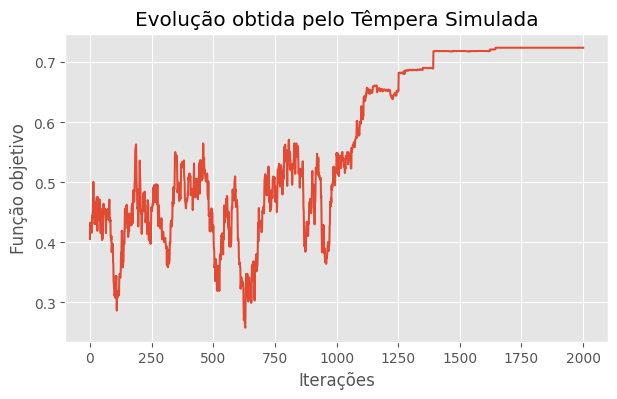

In [241]:
# Encontra o resultado com a execução com reinicializações
simulated_annealing = SimulatedAnnealing(barbecue, compose)
optima = simulated_annealing.run(temperature=1000, cooling_rate=0.99, iterations=2000)

barbecue.print_solution(optima.solution)
optima.show_evolution()

## Algoritmo Genético

In [242]:
class GeneticAlgorithm:
    def __init__(self, model: Barbecue, compose: List[Tuple[Objective, float]]) -> None:
        self.compose = compose
        self.model = model

    def crossover(self, parent1: List[float], parent2: List[float]) -> Tuple[List[float], List[float]]:
        i = random.randint(1, len(parent1) - 2)
        child1 = parent1[:i]
        child2 = parent2[:i]

        for j in range(i, len(parent1)):
            child1.append(parent2[j])
            child2.append(parent1[j])

        return child1, child2

    def tournament(self, population: List[List[float]]) -> List[float]:
        i = random.randint(0, len(population) - 1)
        j = random.randint(0, len(population) - 1)
        while j == i:
            j = random.randint(0, len(population) - 1)

        ifitness = self.model.calculate_fitness(population[i], self.compose)
        jfitness = self.model.calculate_fitness(population[j], self.compose)

        if ifitness > jfitness:
            return population[i]
        else:
            return population[j]

    def mutate(self, solution: List[float], mutate_rate: float) -> List[float]:
        if random.random() < mutate_rate:
            solution = self.model.mutate_solution(solution)
        return solution
    
    def best_individual(self, population: List[List[float]]) -> List[float]:
        best_solution: List[float] = None
        best_fitness: float = 0

        for solution in population:
            fitness = self.model.calculate_fitness(solution, self.compose)
            if fitness > best_fitness:
                best_solution = solution
                best_fitness = fitness

        return best_solution

    def run(self, n_population=50, generations=2000, mutate_rate=0.1) -> Optima:
        population = [self.model.random_solution() for _ in range(0, n_population)]
        current_solution = self.best_individual(population)
        current_fitness = self.model.calculate_fitness(current_solution, self.compose)
        hist: List[float] = [current_fitness]
        
        for i in range(0, generations):
            print(f"Geração {i + 1}", end="\r")
            new_population = []

            while len(new_population) != n_population:
                parent1 = self.tournament(population)
                parent2 = self.tournament(population)
                childs = self.crossover(parent1, parent2)
                
                for solution in childs:
                    if self.model.valid_solution(solution) and len(new_population) < n_population:
                        solution = self.mutate(solution, mutate_rate)
                        new_population.append(solution)
            
            population = new_population
            current_solution = self.best_individual(population)
            current_fitness = self.model.calculate_fitness(current_solution, self.compose)
            hist.append(current_fitness)

        optima = Optima("Algoritmo Genético")
        optima.solution = current_solution
        optima.fitness = current_fitness
        optima.hist_fitness = hist
        return optima

### Execuções

**** Apresentando especificidades da solução ****
Total gasto: 100.0%
Massa atingida: 65.4%
Índice de variedade: 0.39

Alcatra: R$ 38.39 (0.8 kg)
Linguiça: R$ 15.99 (0.8 kg)
Pernil: R$ 12.79 (0.8 kg)
Lombo: R$ 18.69 (1.1 kg)
Picanha: R$ 54.39 (0.8 kg)
Pão de Alho: R$ 159.7 (8.0 kg)

***** Avaliação de desempenho do Algoritmo Genético *****
Fitness inicial: 0.549
Fitness final: 0.652
Evolução 18.7%


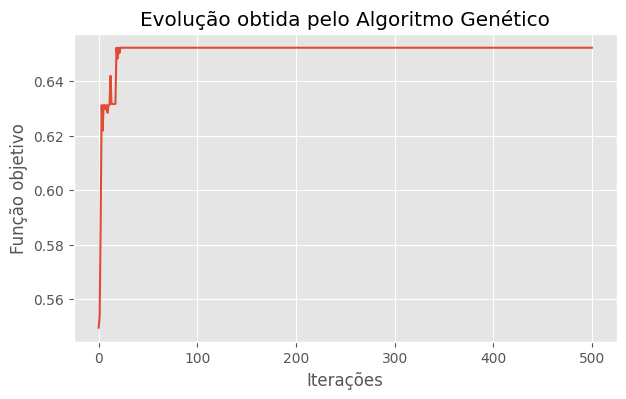

In [264]:
# Encontra o resultado com a execução com reinicializações
genetic_algoritm = GeneticAlgorithm(barbecue, compose)
optima = genetic_algoritm.run(n_population=50, generations=500, mutate_rate=0.3)

barbecue.print_solution(optima.solution)
optima.show_evolution()